In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import matplotlib.colors as colors

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view 

import tqdm
import collections
try:
    import cPickle as pickle
except:
    import pickle

import setigen as stg
import blscint as bls
from blscint.observations.organization import DSFile, DSPointing, DSCadence
from blscint.remote import dsc_cadence 

import scipy.special
import scipy.stats
from astropy.stats import sigma_clip

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import pandas as pd
import sqlite3

import jort
import os
import copy
import shutil
import psutil
from pathlib import Path
import contextlib
import subprocess

import sys 
sys.path.insert(0, '../brkl-111_dedoppler_pipeline')
import survey_direction_filter as sdf

DATA_DIR = Path("/datax2/users/bryanb")
DB_PATH = DATA_DIR / "pipeline.sqlite3"
DIAGSTAT_DIR = DATA_DIR / "scintillation_diagstats"
FIGURES_DIR = Path("/home/bryanb/scintillation_project/scintillation_search_paper/scintillation-search-paper/figures/")

model_frame = stg.Frame.from_backend_params(fchans=256, 
                                            obs_length=600,
                                            int_factor=7)
model_frame.get_params()

{'fchans': 256,
 'tchans': 239,
 'df': 2.7939677238464355,
 'dt': 2.505397589333333,
 'fch1': 6000000000.0,
 'ascending': False}

In [2]:
%matplotlib inline

First, load in all cadence info:

In [3]:
tr = jort.Tracker()
tr.start('load cadences')
with open('full_processed_cadences.pickle', 'rb') as f:
    cadence_list = pickle.load(f)
tr.stop()
tr.report()

len(cadence_list)

load cadences.stop INFO     Elapsed time: 291.5 s

Session: None
load cadences | 291.5 s ± 0.0 s per iteration, n = 1



37

Then load in NGP pointing information:

In [4]:
_, NGP_pointings = sdf.construct_cadence_list(sdf.nested_target_list)
len(NGP_pointings)

Completed session 0 (1 of 5)
Completed session 1 (2 of 5)
Completed session 2 (3 of 5)
Completed session 3 (4 of 5)
Completed session 4 (5 of 5)


5

Collecting all hits from target cadences:

In [5]:
hits_dfs = []
events_dfs = []
partial_events_dfs = []
for c in cadence_list:
    events_dfs.append(c.events)
    partial_events_dfs.append(c.partial_events)
    for p in c:
        # hits_df = p.hits[p.hits['node']=='blc61']
        hits_df = p.hits
        hits_dfs.append(hits_df)
df_hits = pd.concat(hits_dfs)
df_events = pd.concat(events_dfs)
df_partial_events = pd.concat(partial_events_dfs)
print(df_hits.shape)
print(df_events.shape)
print(df_partial_events.shape)
df_hits.head()

(1277325, 610)
(12036, 613)
(106096, 613)


,TopHitNum,DriftRate,SNR,Uncorrected_Frequency,Corrected_Frequency,ChanIndx,FreqStart,FreqEnd,SEFD,SEFD_freq,...,num_hits_rfi_DIAG_SCINT_GC_C10_0028,idx_hits_rfi_DIAG_SCINT_GC_C10_0028,num_hits_DIAG_SCINT_GC_C12_0029,idx_hits_DIAG_SCINT_GC_C12_0029,num_hits_rfi_DIAG_SCINT_GC_C12_0029,idx_hits_rfi_DIAG_SCINT_GC_C12_0029,num_hits_DIAG_SCINT_GC_C10_0026,idx_hits_DIAG_SCINT_GC_C10_0026,num_hits_rfi_DIAG_SCINT_GC_C10_0026,idx_hits_rfi_DIAG_SCINT_GC_C10_0026
0,1,0.126824,10.069126,8438.699626,8438.699626,94925,8438.712406,8438.686850,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.004373,142.755524,8438.500000,8438.500000,166374,8438.512780,8438.487223,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.100585,395.154938,8438.399719,8438.399719,202266,8438.412499,8438.386942,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.056852,3406.843262,8438.099815,8438.099815,309606,8438.112594,8438.087038,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.104958,311.695190,8437.987648,8437.987648,349752,8438.000428,8437.974871,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
vars(p).keys()

dict_keys(['hits', 'excluded_nodes', 'nodes', 'missing_nodes', 'order_label', 'session_idx', 'unix', 'mjd', 'target', 'scan', 'ds_fn_template', 'data_fn_template'])

200 bins


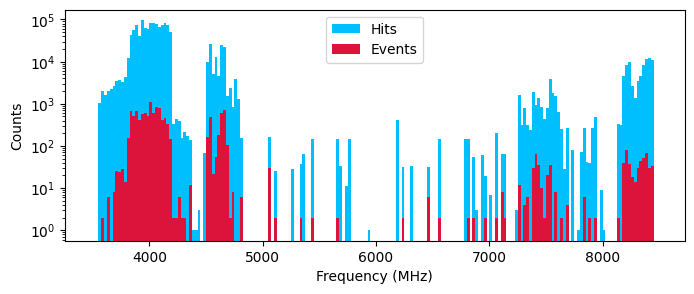

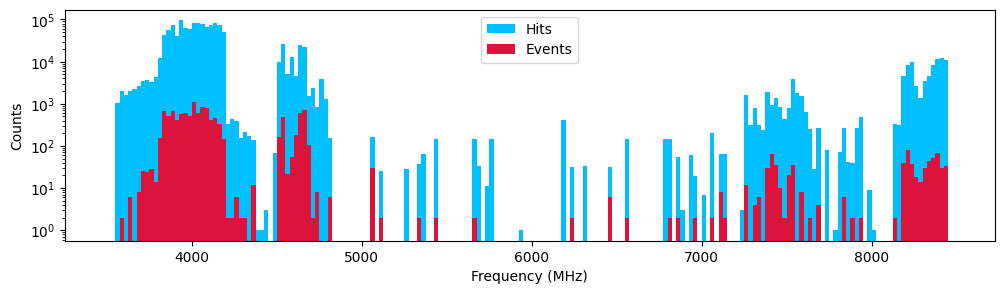

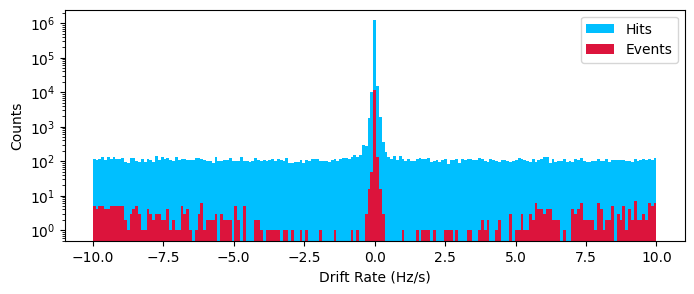

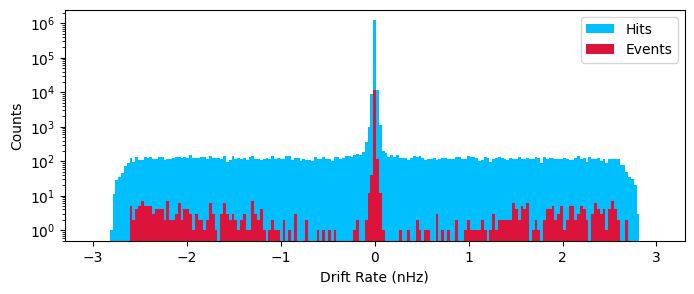

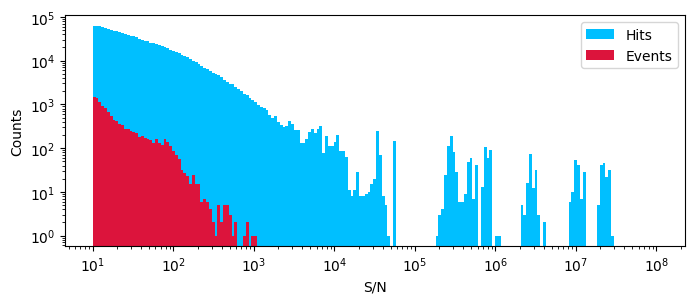

In [7]:
alpha = 1
colors = ['deepskyblue', 'crimson', 'maroon']
colors = ['deepskyblue', 'crimson', 'crimson']
show_partial = False

dbin = 25
bins_frequency = np.arange(3500, 8500, dbin)
print(len(bins_frequency), 'bins')

fig = plt.figure(figsize=(8, 3))
plt.hist(df_hits['Uncorrected_Frequency'], 
         bins=bins_frequency,
         alpha=alpha,
         color=colors[0],
         label='Hits')
if show_partial:
    plt.hist(df_partial_events['Uncorrected_Frequency'], 
             bins=bins_frequency, 
             alpha=alpha,
             color=colors[1],
             label='Partial Events')
plt.hist(df_events['Uncorrected_Frequency'], 
         bins=bins_frequency, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Counts')
plt.legend()

plt.show()

fig = plt.figure(figsize=(12, 3))
plt.hist(df_hits['Uncorrected_Frequency'], 
         bins=bins_frequency,
         alpha=alpha,
         color=colors[0],
         label='Hits')
if show_partial:
    plt.hist(df_partial_events['Uncorrected_Frequency'], 
             bins=bins_frequency, 
             alpha=alpha,
             color=colors[1],
             label='Partial Events')
plt.hist(df_events['Uncorrected_Frequency'], 
         bins=bins_frequency, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Counts')
plt.legend()

plt.savefig(FIGURES_DIR / 'results_frequency.pdf', bbox_inches='tight')
plt.show()


bins_driftrate = np.linspace(-10, 10, 200)
fig = plt.figure(figsize=(8, 3))
plt.hist(df_hits['DriftRate'], 
         bins=bins_driftrate, 
         alpha=alpha,
         color=colors[0],
         label='Hits')
if show_partial:
    plt.hist(df_partial_events['DriftRate'],
             bins=bins_driftrate, 
             alpha=alpha,
             color=colors[1],
             label='Partial Events')
plt.hist(df_events['DriftRate'],
         bins=bins_driftrate,
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Drift Rate (Hz/s)')
plt.ylabel('Counts')
plt.legend()

plt.savefig(FIGURES_DIR / 'results_driftrate.pdf', bbox_inches='tight')
plt.show()


bins_nanodriftrate = np.linspace(-3, 3, 200)
fig = plt.figure(figsize=(8, 3))
plt.hist(df_hits['DriftRate'] / (df_hits['Uncorrected_Frequency'] / 1000), 
         bins=bins_nanodriftrate, 
         alpha=alpha,
         color=colors[0],
         label='Hits')
if show_partial:
    plt.hist(df_partial_events['DriftRate'] / (df_partial_events['Uncorrected_Frequency'] / 1000),
             bins=bins_nanodriftrate, 
             alpha=alpha,
             color=colors[1],
             label='Partial Events')
plt.hist(df_events['DriftRate'] / (df_events['Uncorrected_Frequency'] / 1000),
         bins=bins_nanodriftrate,
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Drift Rate (nHz)')
plt.ylabel('Counts')
plt.legend()

plt.savefig(FIGURES_DIR / 'results_nanodriftrate.pdf', bbox_inches='tight')
plt.show()


bins_snr = 10**np.linspace(1, 8, 200)
fig = plt.figure(figsize=(8, 3))
plt.hist(df_hits['SNR'], 
         bins=bins_snr, 
         alpha=alpha,
         color=colors[0],
         label='Hits')
if show_partial:
    plt.hist(df_partial_events['SNR'], 
             bins=bins_snr,
             alpha=alpha,
             color=colors[1],
             label='Partial Events')
plt.hist(df_events['SNR'],
         bins=bins_snr, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S/N')
plt.ylabel('Counts')
plt.legend()

plt.savefig(FIGURES_DIR / 'results_snr.pdf', bbox_inches='tight')
plt.show()

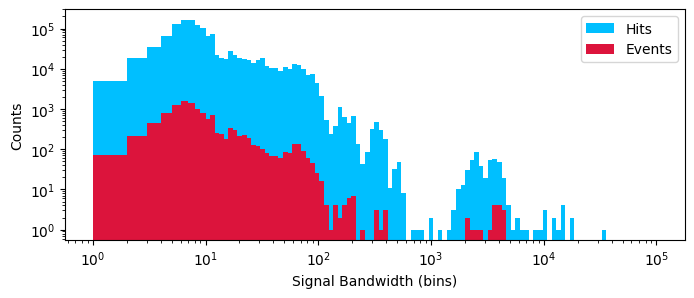

In [70]:

fig = plt.figure(figsize=(8, 3))

alpha = 1
colors = ['deepskyblue', 'crimson', 'crimson']
show_partial=False
hist_func = lambda df: df['r'] - df['l']

# bins = 100
bins_bw = 10**np.linspace(1, 5, 100)
bins_bw = np.concatenate([np.arange(1, 10), bins_bw])
# bins_bw=np.linspace(1, 4000, 4000)
plt.hist(hist_func(df_hits), 
         bins=bins_bw,
         alpha=alpha,
         color=colors[0],
         label='Hits')
if show_partial:
    plt.hist(hist_func(df_partial_events), 
             bins=bins_bw, 
             alpha=alpha,
             color=colors[1],
             label='Partial Events')
plt.hist(hist_func(df_events), 
         bins=bins_bw, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Signal Bandwidth (bins)')
plt.ylabel('Counts')
plt.legend()

plt.savefig(FIGURES_DIR / 'results_bw_full_range.pdf', bbox_inches='tight')
plt.show()

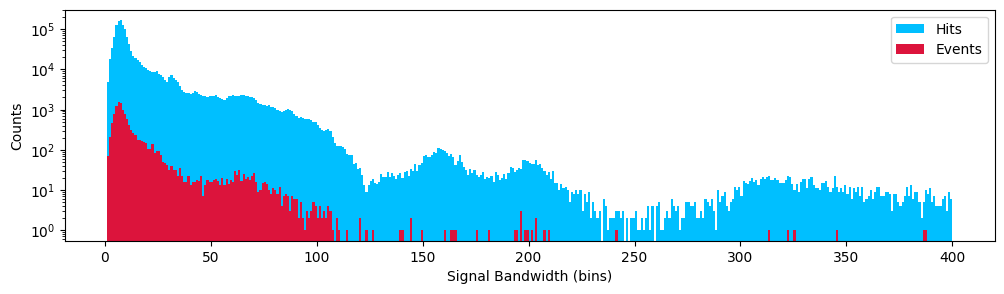

In [42]:
fig = plt.figure(figsize=(12, 3))

alpha = 1
colors = ['deepskyblue', 'crimson', 'crimson']
show_partial=False
hist_func = lambda df: df['r'] - df['l']

# bins = 100
# bins_bw = 10**np.linspace(0, 5, 100)
bins_bw=np.linspace(1, 400, 400)
plt.hist(hist_func(df_hits), 
         bins=bins_bw,
         alpha=alpha,
         color=colors[0],
         label='Hits')
if show_partial:
    plt.hist(hist_func(df_partial_events), 
             bins=bins_bw, 
             alpha=alpha,
             color=colors[1],
             label='Partial Events')
plt.hist(hist_func(df_events), 
         bins=bins_bw, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Signal Bandwidth (bins)')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [40]:
128212+162616+166802+124993+102226

684849

In [10]:
df_hits[[c for c in df_hits.columns if 'hit' not in c]].head()

,TopHitNum,DriftRate,SNR,Uncorrected_Frequency,Corrected_Frequency,ChanIndx,FreqStart,FreqEnd,SEFD,SEFD_freq,...,lag1,lag2,fit_t_d,fit_A,fit_W,fchans,l,r,data_fn,node
0,1,0.126824,10.069126,8438.699626,8438.699626,94925,8438.712406,8438.686850,0.0,0.0,...,-0.074467,0.018320,0.007757,1.291355e-06,0.999999,256,102.0,141.0,/datax2/users/bryanb/blc00_guppi_60089_14928_D...,blc00
1,2,-0.004373,142.755524,8438.500000,8438.500000,166374,8438.512780,8438.487223,0.0,0.0,...,-0.057147,0.073676,61.572672,1.064598e-02,0.989354,256,126.0,128.0,/datax2/users/bryanb/blc00_guppi_60089_14928_D...,blc00
2,3,0.100585,395.154938,8438.399719,8438.399719,202266,8438.412499,8438.386942,0.0,0.0,...,0.062206,-0.010367,98.038609,7.943342e-03,0.992057,256,105.0,140.0,/datax2/users/bryanb/blc00_guppi_60089_14928_D...,blc00
3,4,0.056852,3406.843262,8438.099815,8438.099815,309606,8438.112594,8438.087038,0.0,0.0,...,-0.010589,-0.091829,0.024973,7.927777e-07,0.999999,256,112.0,136.0,/datax2/users/bryanb/blc00_guppi_60089_14928_D...,blc00
4,5,0.104958,311.695190,8437.987648,8437.987648,349752,8438.000428,8437.974871,0.0,0.0,...,-0.056319,0.000145,0.106552,5.598504e-08,1.000000,256,78.0,174.0,/datax2/users/bryanb/blc00_guppi_60089_14928_D...,blc00


In [32]:
df_large_bw = df_hits[df_hits['r']-df_hits['l']>1000][[c for c in df_hits.columns if 'hit' not in c]]
print(df_large_bw.shape)

# import blscint.remote as blsr

# for i, row in tqdm.tqdm(df_large_bw.sample(20).iterrows()):
#         print(row)
#         fr = blsr.frame_from_df(row)
#         fr.plot()
#         plt.savefig(f"figures/large_bw/{row['node']}_{row['TopHitNum']}.pdf", bbox_inches='tight')
#         plt.show()


df_large_bw.head()

(460, 26)


,TopHitNum,DriftRate,SNR,Uncorrected_Frequency,Corrected_Frequency,ChanIndx,FreqStart,FreqEnd,SEFD,SEFD_freq,...,lag1,lag2,fit_t_d,fit_A,fit_W,fchans,l,r,data_fn,node
1982,5,-9.861684,41.979870,4365.057047,4365.057047,587756,4365.069827,4365.044271,0.0,0.0,...,0.988345,0.968023,39.212428,1.000000,1.707392e-16,16384,6578.0,10549.0,/datax2/users/bryanb/blc63_guppi_60089_14928_D...,blc63
1983,6,-0.669108,30.823067,4346.763913,4346.763913,843668,4346.776692,4346.751136,0.0,0.0,...,0.981779,0.962525,37.857754,1.000000,7.982974e-17,16384,6158.0,10390.0,/datax2/users/bryanb/blc63_guppi_60089_14928_D...,blc63
1985,2,-7.460769,14.510163,4262.849908,4262.849908,468956,4262.862688,4262.837132,0.0,0.0,...,0.921988,0.866731,33.043517,0.991847,8.152633e-03,16384,6727.0,9946.0,/datax2/users/bryanb/blc64_guppi_60089_14928_D...,blc64
1986,3,-3.879075,30.848635,4250.079428,4250.079428,845385,4250.092207,4250.066651,0.0,0.0,...,0.980653,0.957021,37.182601,1.000000,8.930609e-17,16384,6287.0,10305.0,/datax2/users/bryanb/blc64_guppi_60089_14928_D...,blc64
1987,4,-8.051158,14.110777,4241.807702,4241.807702,660223,4241.820482,4241.794925,0.0,0.0,...,0.947933,0.928851,35.021196,1.000000,7.597784e-16,8192,3068.0,5429.0,/datax2/users/bryanb/blc64_guppi_60089_14928_D...,blc64


In [33]:
df_large_bw_events = df_events[df_events['r']-df_events['l']>1000][[c for c in df_hits.columns if 'hit' not in c]]
print(df_large_bw_events.shape)

# import blscint.remote as blsr

# for i, row in tqdm.tqdm(df_large_bw.sample(20).iterrows()):
#         print(row)
#         fr = blsr.frame_from_df(row)
#         fr.plot()
#         plt.savefig(f"figures/large_bw/{row['node']}_{row['TopHitNum']}.pdf", bbox_inches='tight')
#         plt.show()


df_large_bw_events.head()

(17, 26)


,TopHitNum,DriftRate,SNR,Uncorrected_Frequency,Corrected_Frequency,ChanIndx,FreqStart,FreqEnd,SEFD,SEFD_freq,...,lag1,lag2,fit_t_d,fit_A,fit_W,fchans,l,r,data_fn,node
1508,3,-1.906738,63.655590,4365.011148,4365.011148,604184,4365.023928,4364.998371,0.0,0.0,...,0.967949,0.919560,24.754954,0.999912,8.862848e-05,16384,6148.0,10591.0,/datax2/users/bryanb/blc73_guppi_60145_04961_D...,blc73
1581,5,-8.610934,42.587502,4235.103314,4235.103314,962665,4235.116093,4235.090537,0.0,0.0,...,0.990423,0.976432,36.882654,1.000000,5.495393e-17,16384,6298.0,10090.0,/datax2/users/bryanb/blc74_guppi_60145_06836_D...,blc74
1671,7,9.227563,114.065933,4235.076690,4235.076690,972194,4235.089470,4235.063913,0.0,0.0,...,0.986848,0.969923,47.099161,1.000000,4.314777e-07,16384,5754.0,9904.0,/datax2/users/bryanb/blc74_guppi_60145_08070_D...,blc74
2922,4,-9.118232,36.912743,4364.966411,4364.966411,620196,4364.979191,4364.953634,0.0,0.0,...,0.939416,0.863354,51.320654,0.828514,1.714855e-01,16384,6574.0,10478.0,/datax2/users/bryanb/blc73_guppi_60275_56786_D...,blc73
2900,3,-5.663362,46.092693,4364.950466,4364.950466,625903,4364.963246,4364.937689,0.0,0.0,...,0.982771,0.971278,77.314377,1.000000,3.608250e-15,8192,3023.0,5704.0,/datax2/users/bryanb/blc73_guppi_60275_58027_D...,blc73


200 bins


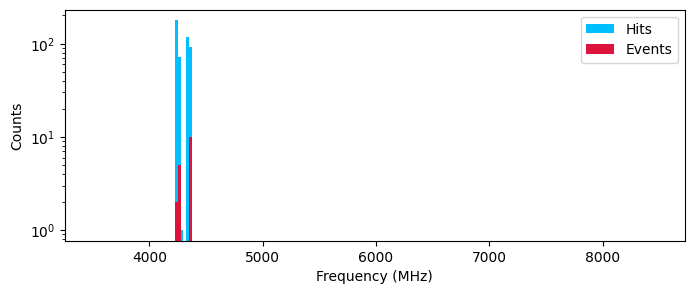

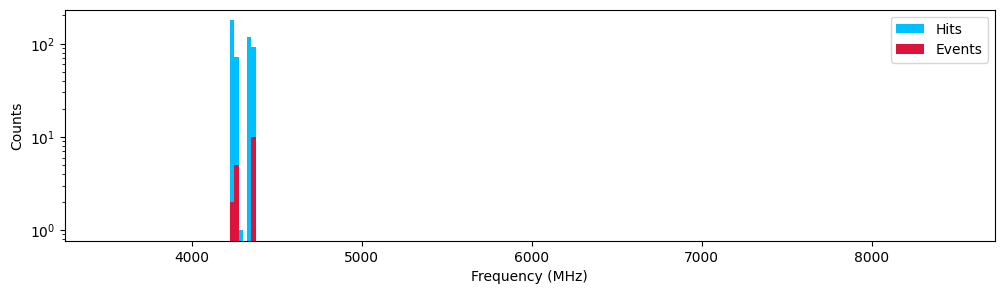

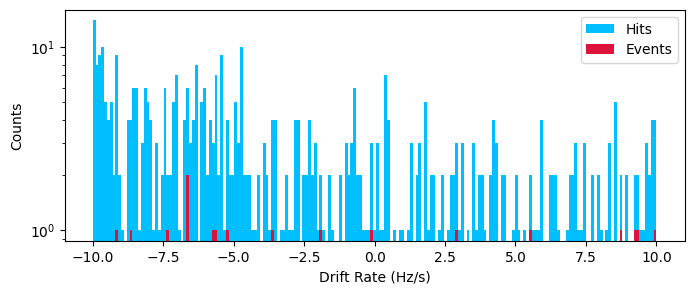

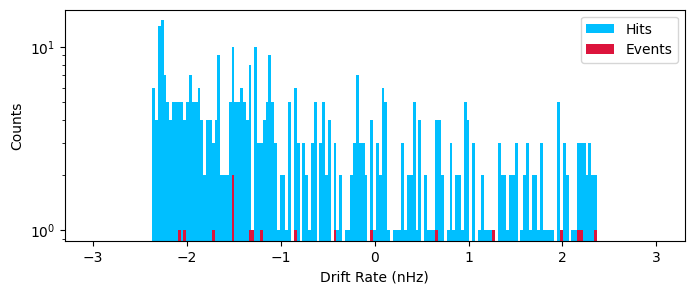

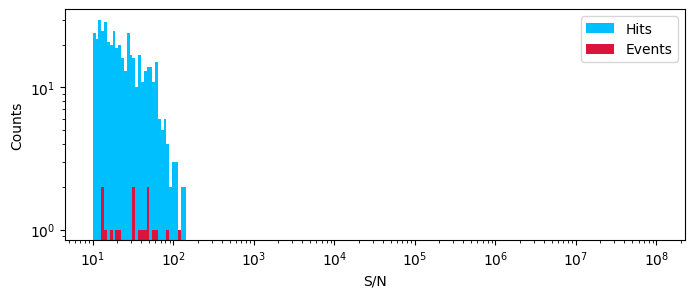

In [34]:
alpha = 1
colors = ['deepskyblue', 'crimson', 'maroon']
colors = ['deepskyblue', 'crimson', 'crimson']
show_partial = False

dbin = 25
bins_frequency = np.arange(3500, 8500, dbin)
print(len(bins_frequency), 'bins')

fig = plt.figure(figsize=(8, 3))
plt.hist(df_large_bw['Uncorrected_Frequency'], 
         bins=bins_frequency,
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(df_large_bw_events['Uncorrected_Frequency'], 
         bins=bins_frequency, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Counts')
plt.legend()

plt.show()

fig = plt.figure(figsize=(12, 3))
plt.hist(df_large_bw['Uncorrected_Frequency'], 
         bins=bins_frequency,
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(df_large_bw_events['Uncorrected_Frequency'], 
         bins=bins_frequency, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Counts')
plt.legend()

plt.savefig(FIGURES_DIR / 'results_frequency.pdf', bbox_inches='tight')
plt.show()


bins_driftrate = np.linspace(-10, 10, 200)
fig = plt.figure(figsize=(8, 3))
plt.hist(df_large_bw['DriftRate'], 
         bins=bins_driftrate, 
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(df_large_bw_events['DriftRate'],
         bins=bins_driftrate,
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Drift Rate (Hz/s)')
plt.ylabel('Counts')
plt.legend()

plt.show()


bins_nanodriftrate = np.linspace(-3, 3, 200)
fig = plt.figure(figsize=(8, 3))
plt.hist(df_large_bw['DriftRate'] / (df_large_bw['Uncorrected_Frequency'] / 1000), 
         bins=bins_nanodriftrate, 
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(df_large_bw_events['DriftRate'] / (df_large_bw_events['Uncorrected_Frequency'] / 1000),
         bins=bins_nanodriftrate,
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
plt.xlabel('Drift Rate (nHz)')
plt.ylabel('Counts')
plt.legend()

plt.show()


bins_snr = 10**np.linspace(1, 8, 200)
fig = plt.figure(figsize=(8, 3))
plt.hist(df_large_bw['SNR'], 
         bins=bins_snr, 
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(df_large_bw_events['SNR'],
         bins=bins_snr, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S/N')
plt.ylabel('Counts')
plt.legend()

plt.show()

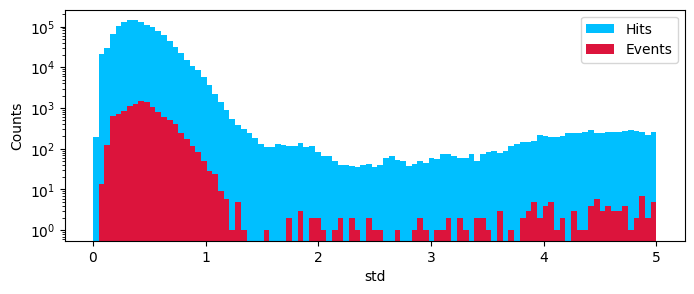

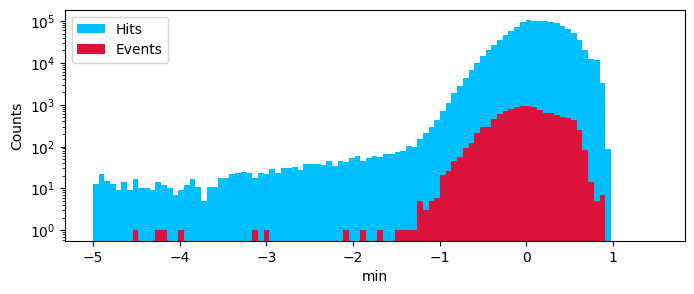

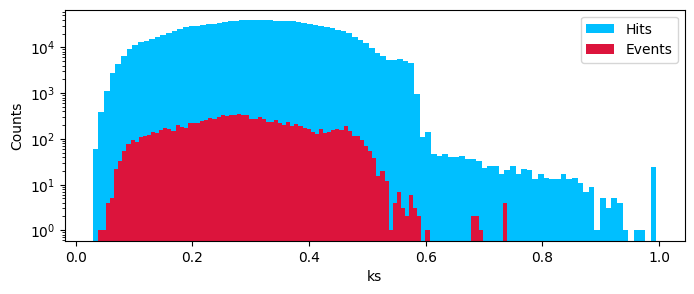

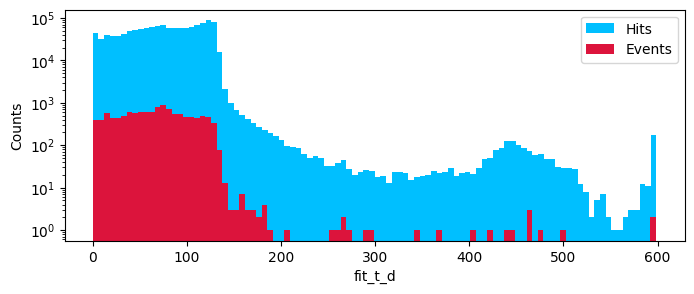

In [82]:
fig = plt.figure(figsize=(8, 3))

alpha = 1
colors = ['deepskyblue', 'crimson', 'crimson']
show_partial=False
hist_func = lambda df: df['std']

bins = np.linspace(0, 5, 100)
# bins_bw = 10**np.linspace(1, 5, 100)
# bins_bw = np.concatenate([np.arange(1, 10), bins_bw])
# bins_bw=np.linspace(1, 4000, 4000)
plt.hist(hist_func(df_hits), 
         bins=bins,
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(hist_func(df_events), 
         bins=bins, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
# plt.xscale('log') 
plt.xlabel('std')
plt.ylabel('Counts')
plt.legend()

# plt.savefig(FIGURES_DIR / 'results_bw_full_range.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 3))
hist_func = lambda df: df['min']

bins = np.linspace(-5, 1.5, 100)
# bins_bw = 10**np.linspace(1, 5, 100)
# bins_bw = np.concatenate([np.arange(1, 10), bins_bw])
# bins_bw=np.linspace(1, 4000, 4000)
plt.hist(hist_func(df_hits), 
         bins=bins,
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(hist_func(df_events), 
         bins=bins, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('min')
plt.ylabel('Counts')
plt.legend()

# plt.savefig(FIGURES_DIR / 'results_bw_full_range.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 3))
hist_func = lambda df: df['ks']

bins = 100
# bins_bw = 10**np.linspace(1, 5, 100)
# bins_bw = np.concatenate([np.arange(1, 10), bins_bw])
# bins_bw=np.linspace(1, 4000, 4000)
plt.hist(hist_func(df_hits), 
         bins=bins,
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(hist_func(df_events), 
         bins=bins, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('ks')
plt.ylabel('Counts')
plt.legend()

# plt.savefig(FIGURES_DIR / 'results_bw_full_range.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 3))
hist_func = lambda df: df['fit_t_d']

bins = 100
# bins_bw = 10**np.linspace(1, 5, 100)
# bins_bw = np.concatenate([np.arange(1, 10), bins_bw])
# bins_bw=np.linspace(1, 4000, 4000)
plt.hist(hist_func(df_hits), 
         bins=bins,
         alpha=alpha,
         color=colors[0],
         label='Hits')
plt.hist(hist_func(df_events), 
         bins=bins, 
         alpha=alpha,
         color=colors[2],
         label='Events')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('fit_t_d')
plt.ylabel('Counts')
plt.legend()

# plt.savefig(FIGURES_DIR / 'results_bw_full_range.pdf', bbox_inches='tight')
plt.show()

Try signal manager for NGP observations

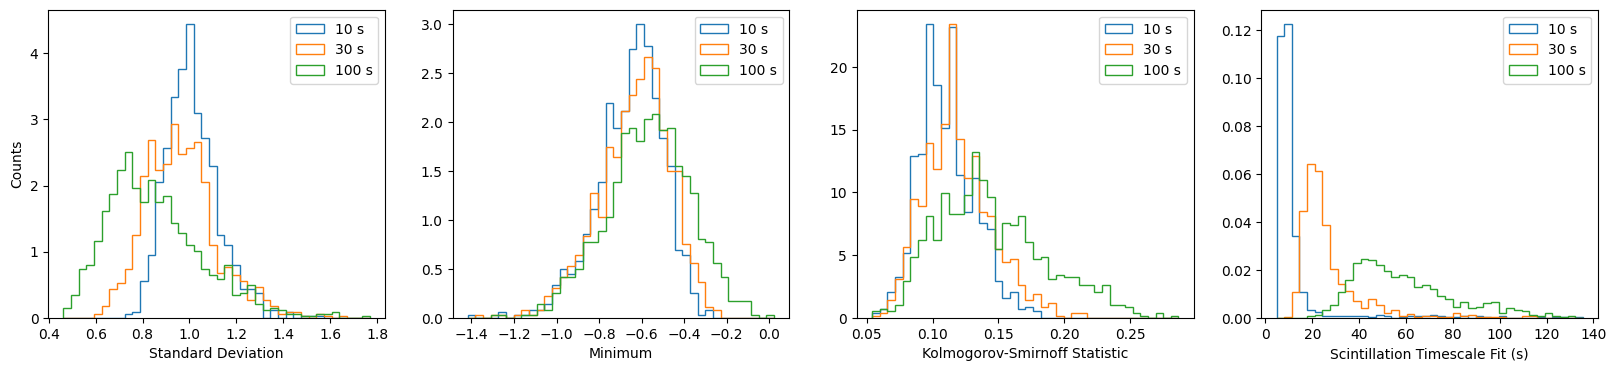

In [95]:
manager = bls.SignalManager() 
t_ds = [10, 30, 100]
for t_d in t_ds:
    manager.add_synthetic(f"synthetic-t_d{t_d}-snr33.diagstat.csv",
                          label=f"t_d{t_d}") 

filters = [] 
for t_d in t_ds:
    filters.append({
        "label": f"{t_d} s", 
        "df": manager.df[manager.df["label"] == f"t_d{t_d}"],
        'density': True
    })
    
manager.plot_histograms(filters=filters)
plt.show()

In [96]:
for ngpp in NGP_pointings:
    fn = f'NGP{ngpp.session_idx}.csv'
    ngpp.hits.to_csv(fn)
    manager.add_real(fn, label=f'NGP{ngpp.session_idx}')

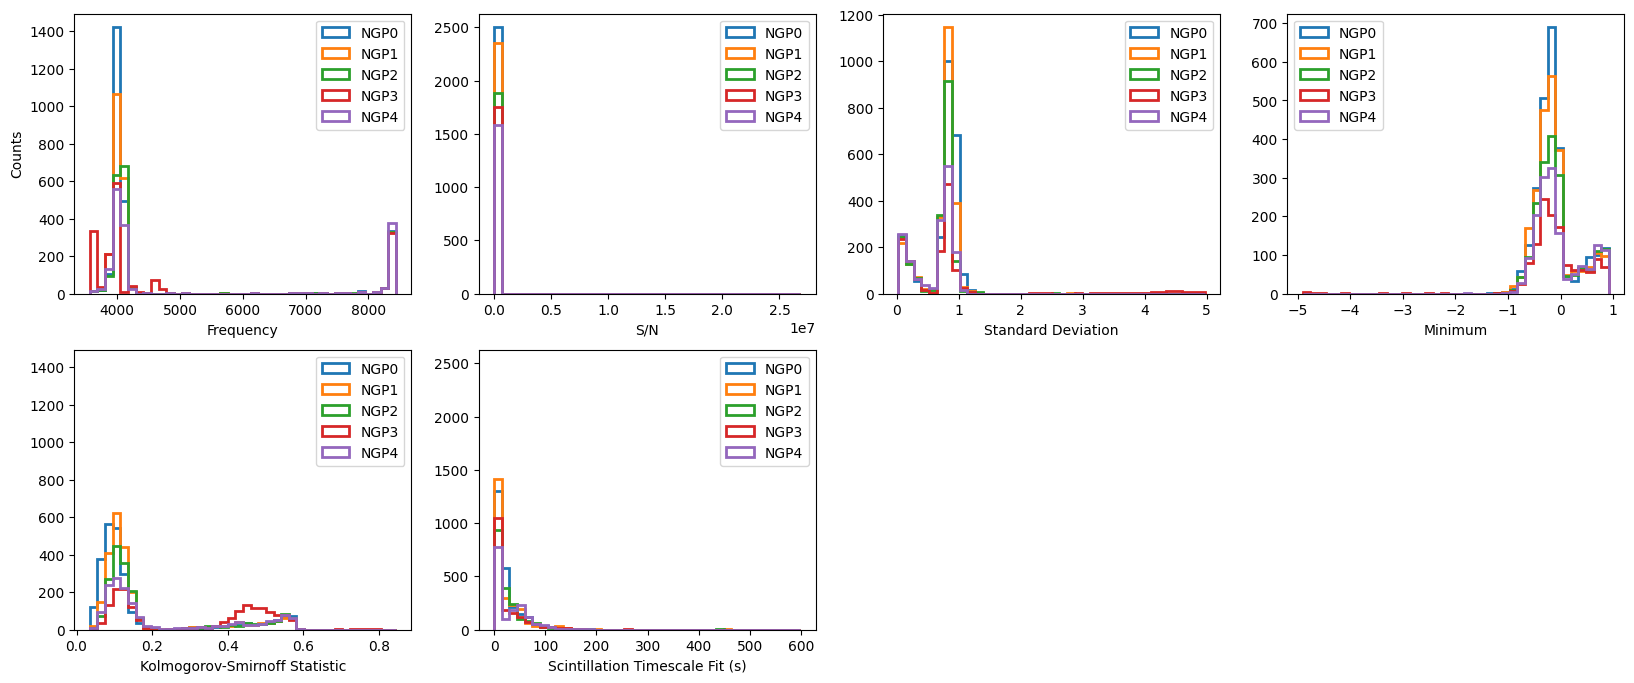

In [98]:
filters = [] 
# for t_d in t_ds:
#     filters.append({
#         "label": f"{t_d} s", 
#         "df": manager.df[manager.df["label"] == f"t_d{t_d}"],
#         'density': True
#     })
for ngpp in NGP_pointings:
    filters.append({
        "label": f'NGP{ngpp.session_idx}', 
        "df": manager.df[manager.df["label"] == f'NGP{ngpp.session_idx}'],
        'linewidth': 2,
        # 'density': True
    })
    
manager.plot_histograms(filters=filters,
                        statistics=['Uncorrected_Frequency', 
                                    'SNR',
                                    'std', 'min', 'ks', 'fit_t_d'], 
                        titles=['Frequency', 'S/N', 'Standard Deviation', 
                                'Minimum', 
                                'Kolmogorov-Smirnoff Statistic', 
                                'Scintillation Timescale Fit (s)'],
                        statistic_bounds=[[3500, 8500],
                                          None,
                                          [0, 5],
                                          [-5, 1],
                                          None,
                                          None])
plt.show()

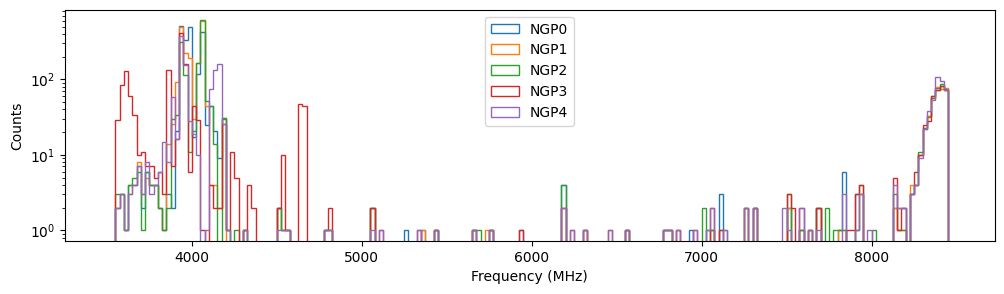

In [102]:
fig = plt.figure(figsize=(12, 3))
for ngpp in NGP_pointings:
    plt.hist(ngpp.hits['Uncorrected_Frequency'], 
             bins=bins_frequency,
             alpha=1,
                            histtype='step', 
             # color=colors[0],
             label=f'NGP{ngpp.session_idx}')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Counts')
plt.legend()

# plt.savefig(FIGURES_DIR / 'results_frequency.pdf', bbox_inches='tight')
plt.show()

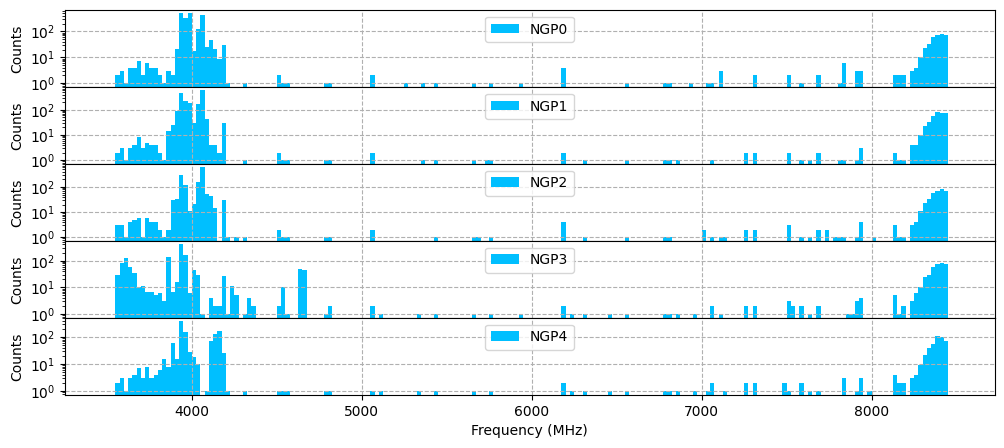

In [171]:
fig = plt.figure(figsize=(12, 5))

gs = grd.GridSpec(5, 
                  1, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  hspace=0.
                 )

for i, ngpp in enumerate(NGP_pointings):
    ax = plt.subplot(gs[i])
    plt.hist(ngpp.hits['Uncorrected_Frequency'], 
             bins=bins_frequency,
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=9)
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.grid(ls='--')
plt.xlabel('Frequency (MHz)')

plt.savefig(FIGURES_DIR / 'results_frequency_NGP.pdf', bbox_inches='tight')
plt.show()

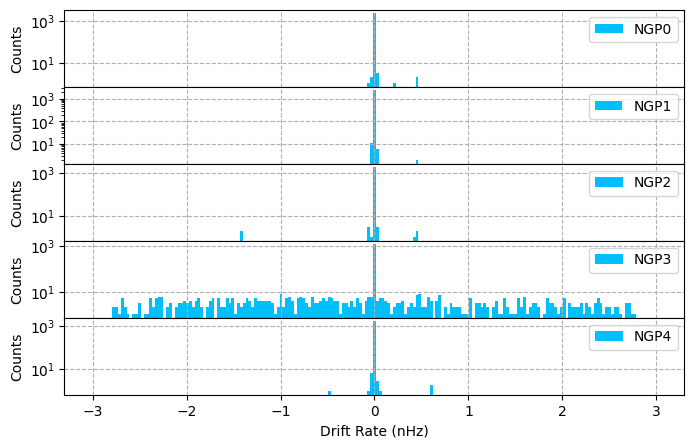

In [172]:
fig = plt.figure(figsize=(8, 5))

gs = grd.GridSpec(5, 
                  1, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  hspace=0.
                 )

for i, ngpp in enumerate(NGP_pointings):
    ax = plt.subplot(gs[i])
    plt.hist(ngpp.hits['DriftRate'] / (ngpp.hits['Uncorrected_Frequency'] / 1000), 
             bins=bins_nanodriftrate,
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=1)
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.grid(ls='--')
plt.xlabel('Drift Rate (nHz)')

plt.savefig(FIGURES_DIR / 'results_nanodriftrate_NGP.pdf', bbox_inches='tight')
plt.show()

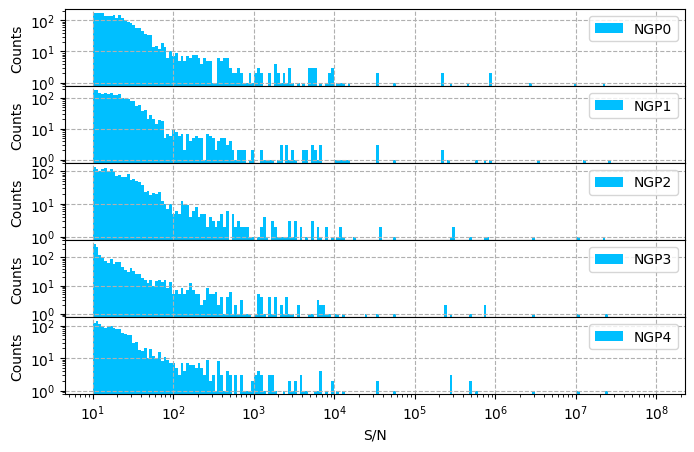

In [173]:
fig = plt.figure(figsize=(8, 5))

gs = grd.GridSpec(5, 
                  1, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  hspace=0.
                 )
bins_snr_ngp = 10**np.linspace(1, 8, 200)
# bins_snr_ngp = 100
for i, ngpp in enumerate(NGP_pointings):
    ax = plt.subplot(gs[i])
    plt.hist(ngpp.hits['SNR'], 
             bins=bins_snr_ngp,
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=1)
    plt.ylabel('Counts')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(ls='--')
plt.xlabel('S/N')

plt.savefig(FIGURES_DIR / 'results_snr_NGP.pdf', bbox_inches='tight')
plt.show()

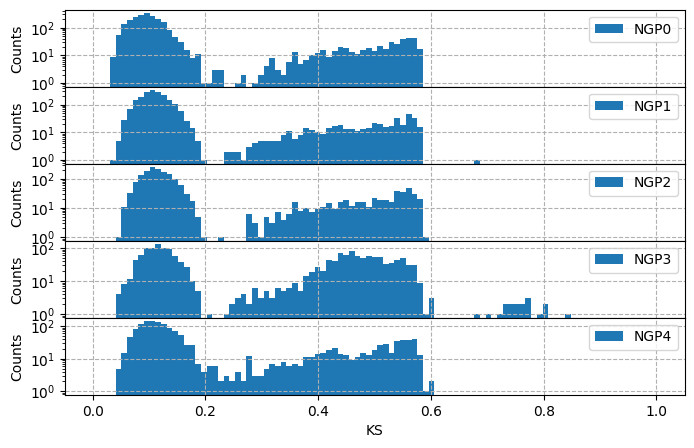

In [162]:
fig = plt.figure(figsize=(8, 5))

gs = grd.GridSpec(5, 
                  1, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  hspace=0.
                 )
# bins_snr_ngp = 100
for i, ngpp in enumerate(NGP_pointings):
    ax = plt.subplot(gs[i])
    plt.hist(ngpp.hits['ks'], 
             bins=np.linspace(0, 1, 100),
             alpha=1,
                            # histtype='step', 
             # color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=1)
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.grid(ls='--')
plt.xlabel('KS')
plt.show()

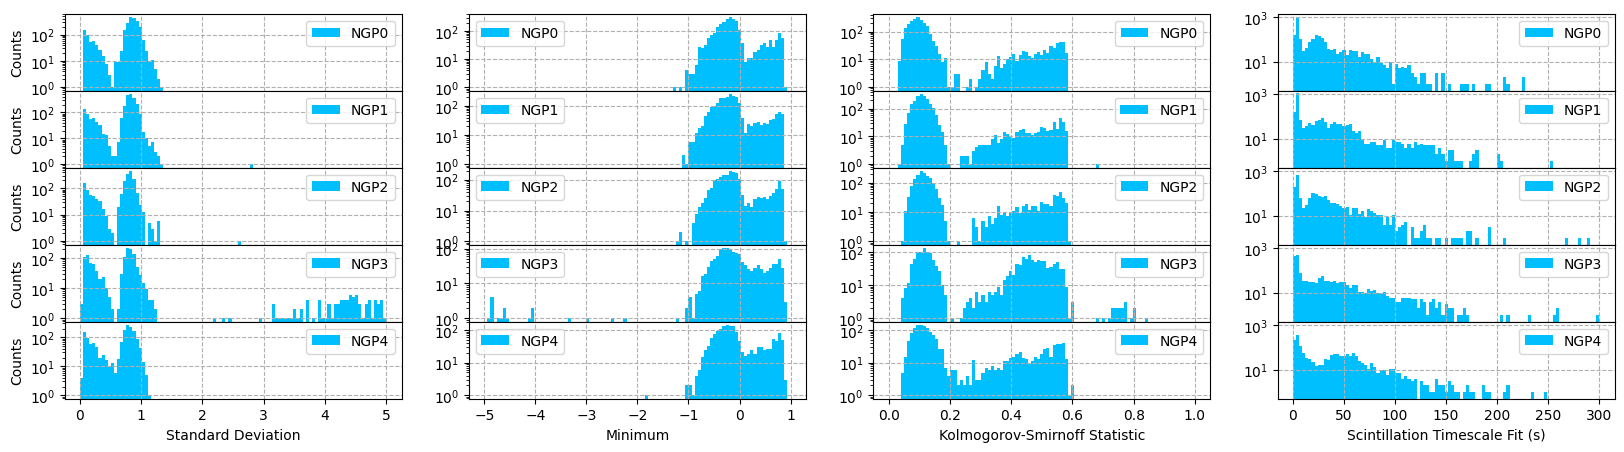

In [206]:
fig = plt.figure(figsize=(20, 5))

gs = grd.GridSpec(5, 
                  4, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  hspace=0.
                 )
# bins_snr_ngp = 100
for i, ngpp in enumerate(NGP_pointings):
    ax = plt.subplot(gs[i, 0])
    plt.hist(ngpp.hits['std'], 
             bins=np.linspace(0, 5, 100),
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=1)
    plt.xlabel('Standard Deviation')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.grid(ls='--')
    ax = plt.subplot(gs[i, 1])
    plt.hist(ngpp.hits['min'], 
             bins=np.linspace(-5, 1, 100),
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=2)
    plt.xlabel('Minimum')
    # plt.ylabel('Counts')
    plt.yscale('log')
    plt.grid(ls='--')
    ax = plt.subplot(gs[i, 2])
    plt.hist(ngpp.hits['ks'], 
             bins=np.linspace(0, 1, 100),
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=1)
    plt.xlabel('Kolmogorov-Smirnoff Statistic')
    # plt.ylabel('Counts')
    plt.yscale('log')
    plt.grid(ls='--')
    ax = plt.subplot(gs[i, 3])
    plt.hist(ngpp.hits['fit_t_d'], 
             bins=np.linspace(0, 300, 100),
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.legend(loc=1)
    plt.xlabel('Scintillation Timescale Fit (s)')
    # plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.5, 1.4e3)
    plt.grid(ls='--')

plt.savefig(FIGURES_DIR / 'results_diagstats_NGP.pdf', bbox_inches='tight')
plt.show()

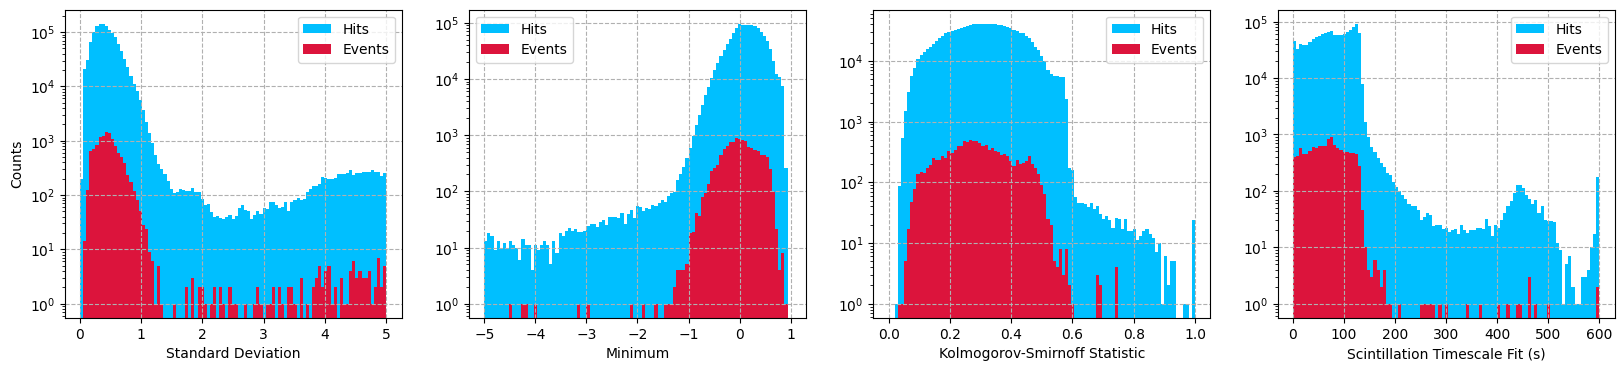

In [207]:
fig = plt.figure(figsize=(20, 4))

gs = grd.GridSpec(1, 
                  4, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  # hspace=0.
                 )
ax = plt.subplot(gs[0])
plt.hist(df_hits['std'], 
         bins=np.linspace(0, 5, 100),
         alpha=1,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['std'], 
         bins=np.linspace(0, 5, 100), 
         alpha=1,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid(ls='--')
ax = plt.subplot(gs[1])
plt.hist(df_hits['min'], 
         bins=np.linspace(-5, 1, 100),
         alpha=1,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['min'], 
         bins=np.linspace(-5, 1, 100), 
         alpha=1,
         color=colors[2],
         label='Events')
plt.legend(loc=2)
plt.xlabel('Minimum')
# plt.ylabel('Counts')
plt.yscale('log')
plt.grid(ls='--')
ax = plt.subplot(gs[2])
plt.hist(df_hits['ks'], 
         bins=np.linspace(0, 1, 100),
         alpha=1,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['ks'], 
         bins=np.linspace(0, 1, 100), 
         alpha=1,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Kolmogorov-Smirnoff Statistic')
# plt.ylabel('Counts')
plt.yscale('log')
plt.grid(ls='--')
ax = plt.subplot(gs[3])
plt.hist(df_hits['fit_t_d'], 
         bins=np.linspace(0, 600, 100),
         alpha=1,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['fit_t_d'], 
         bins=np.linspace(0, 600, 100), 
         alpha=1,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Scintillation Timescale Fit (s)')
# plt.ylabel('Counts')
plt.yscale('log')
# plt.ylim(0.5, 1.4e3)
plt.grid(ls='--')

plt.savefig(FIGURES_DIR / 'results_diagstats.pdf', bbox_inches='tight')
plt.show()

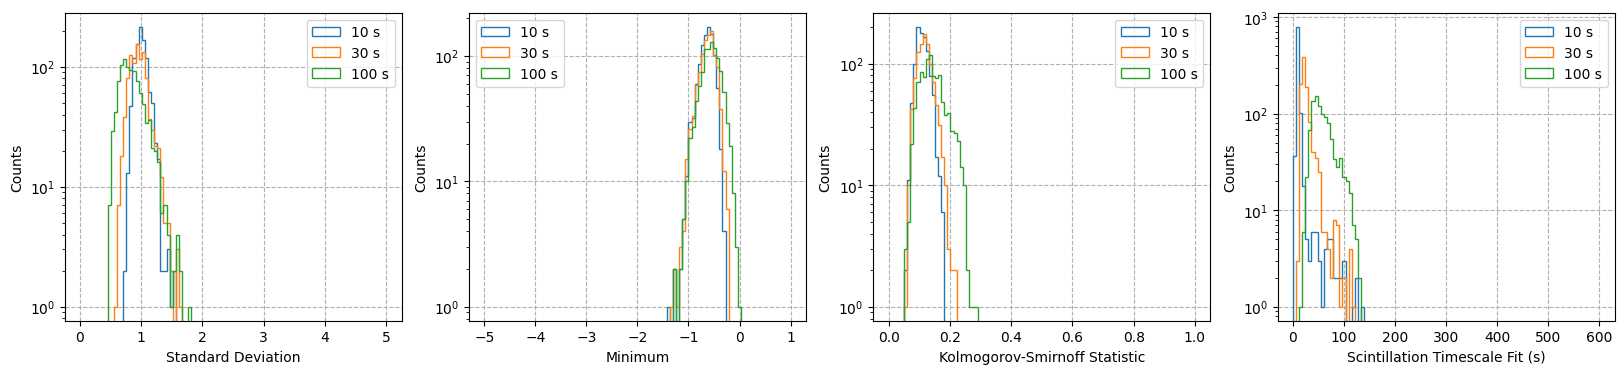

In [192]:
df_t_ds = {}
t_ds = [10, 30, 100]
for t_d in t_ds:
    df_t_ds[t_d] = pd.read_csv(f"synthetic-t_d{t_d}-snr33.diagstat.csv")


fig = plt.figure(figsize=(20, 4))

gs = grd.GridSpec(1, 
                  4, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  # hspace=0.
                 )
ax = plt.subplot(gs[0])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['std'], 
             bins=np.linspace(0, 5, 100),
             alpha=1,histtype='step', 
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid(ls='--')

ax = plt.subplot(gs[1])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['min'], 
             bins=np.linspace(-5, 1, 100),
             alpha=1,histtype='step', 
             label=f'{t_d} s')
plt.legend(loc=2)
plt.xlabel('Minimum')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid(ls='--')

ax = plt.subplot(gs[2])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['ks'], 
             bins=np.linspace(0, 1, 100),
             alpha=1,histtype='step', 
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Kolmogorov-Smirnoff Statistic')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid(ls='--')

ax = plt.subplot(gs[3])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['fit_t_d'], 
             bins=np.linspace(0, 600, 100),
             alpha=1,histtype='step', 
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Scintillation Timescale Fit (s)')
plt.ylabel('Counts')
plt.yscale('log')
# plt.ylim(0.5, 1.4e3)
plt.grid(ls='--')



plt.show()

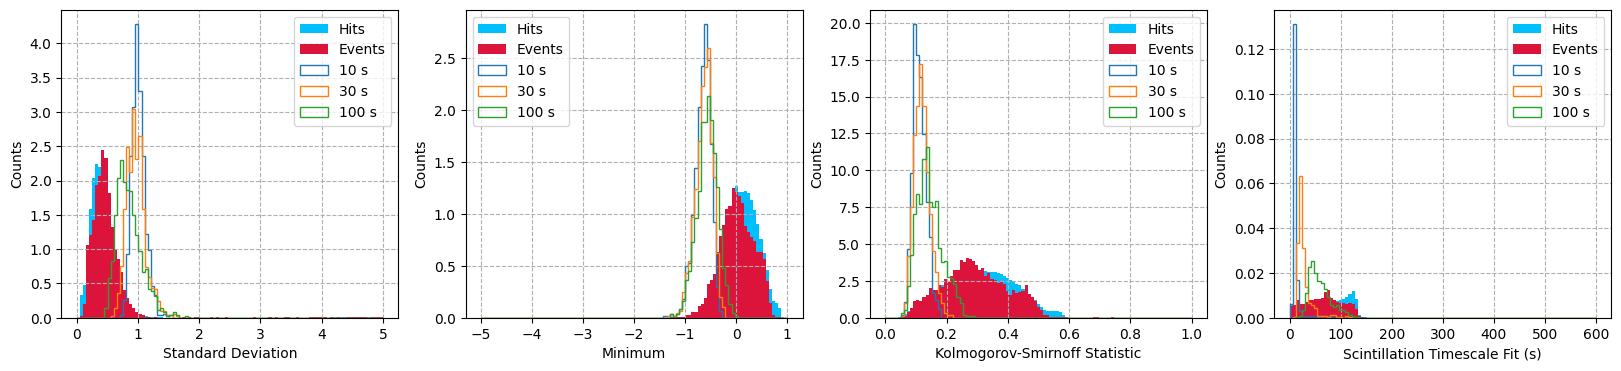

In [194]:
fig = plt.figure(figsize=(20, 4))

gs = grd.GridSpec(1, 
                  4, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  # hspace=0.
                 )
ax = plt.subplot(gs[0])
plt.hist(df_hits['std'], 
         bins=np.linspace(0, 5, 100),
         alpha=1,density=True,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['std'], 
         bins=np.linspace(0, 5, 100), 
         alpha=1,density=True,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid(ls='--')
ax = plt.subplot(gs[1])
plt.hist(df_hits['min'], 
         bins=np.linspace(-5, 1, 100),
         alpha=1,density=True,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['min'], 
         bins=np.linspace(-5, 1, 100), 
         alpha=1,density=True,
         color=colors[2],
         label='Events')
plt.legend(loc=2)
plt.xlabel('Minimum')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid(ls='--')
ax = plt.subplot(gs[2])
plt.hist(df_hits['ks'], 
         bins=np.linspace(0, 1, 100),
         alpha=1,density=True,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['ks'], 
         bins=np.linspace(0, 1, 100), 
         alpha=1,density=True,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Kolmogorov-Smirnoff Statistic')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid(ls='--')
ax = plt.subplot(gs[3])
plt.hist(df_hits['fit_t_d'], 
         bins=np.linspace(0, 600, 100),
         alpha=1,density=True,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['fit_t_d'], 
         bins=np.linspace(0, 600, 100), 
         alpha=1,density=True,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Scintillation Timescale Fit (s)')
plt.ylabel('Counts')
# plt.yscale('log')
# plt.ylim(0.5, 1.4e3)
plt.grid(ls='--')

ax = plt.subplot(gs[0])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['std'], 
             bins=np.linspace(0, 5, 100),
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid(ls='--')

ax = plt.subplot(gs[1])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['min'], 
             bins=np.linspace(-5, 1, 100),
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=2)
plt.xlabel('Minimum')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid(ls='--')

ax = plt.subplot(gs[2])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['ks'], 
             bins=np.linspace(0, 1, 100),
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Kolmogorov-Smirnoff Statistic')
plt.ylabel('Counts')
# plt.yscale('log')
plt.grid(ls='--')

ax = plt.subplot(gs[3])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['fit_t_d'], 
             bins=np.linspace(0, 600, 100),
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Scintillation Timescale Fit (s)')
plt.ylabel('Counts')
# plt.yscale('log')
# plt.ylim(0.5, 1.4e3)
plt.grid(ls='--')

# plt.savefig(FIGURES_DIR / 'results_diagstats.pdf', bbox_inches='tight')
plt.show()

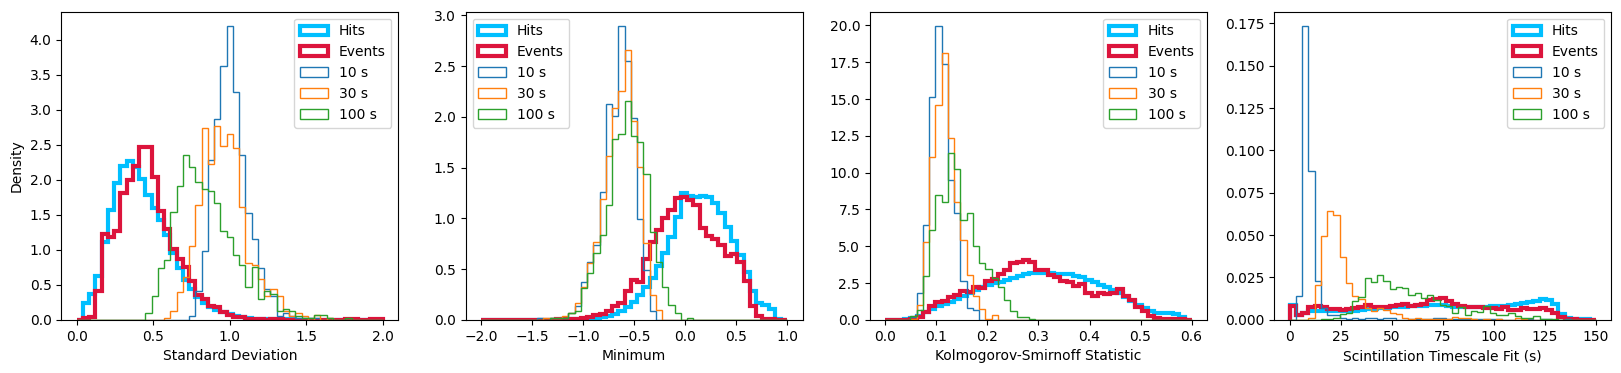

In [204]:
fig = plt.figure(figsize=(20, 4))

gs = grd.GridSpec(1, 
                  4, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  # hspace=0.
                 )
bins_std = np.linspace(0, 2, 50)
bins_min = np.linspace(-2, 1, 50)
bins_ks = np.linspace(0, 0.6, 50)
bins_fit_t_d = np.linspace(0, 150, 50)
lw = 3

ax = plt.subplot(gs[0])
plt.hist(df_hits['std'], 
         bins=bins_std,
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['std'], 
         bins=bins_std, 
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Counts')
# plt.yscale('log')

ax = plt.subplot(gs[1])
plt.hist(df_hits['min'], 
         bins=bins_min,
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['min'], 
         bins=bins_min, 
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[2],
         label='Events')
plt.legend(loc=2)
plt.xlabel('Minimum')
plt.ylabel('Counts')
# plt.yscale('log')

ax = plt.subplot(gs[2])
plt.hist(df_hits['ks'], 
         bins=bins_ks,
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['ks'], 
         bins=bins_ks, 
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Kolmogorov-Smirnoff Statistic')
plt.ylabel('Counts')
# plt.yscale('log')

ax = plt.subplot(gs[3])
plt.hist(df_hits['fit_t_d'], 
         bins=bins_fit_t_d,
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[0],
         label=f'Hits')
plt.hist(df_events['fit_t_d'], 
         bins=bins_fit_t_d, 
         alpha=1,density=True,histtype='step',lw=lw,
         color=colors[2],
         label='Events')
plt.legend(loc=1)
plt.xlabel('Scintillation Timescale Fit (s)')
plt.ylabel('Counts')
# plt.yscale('log')
# plt.ylim(0.5, 1.4e3)


ax = plt.subplot(gs[0])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['std'], 
             bins=bins_std,
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Counts')
# plt.yscale('log')


ax = plt.subplot(gs[1])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['min'], 
             bins=bins_min,
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=2)
plt.xlabel('Minimum')
plt.ylabel('Counts')
# plt.yscale('log')


ax = plt.subplot(gs[2])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['ks'], 
             bins=bins_ks,
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Kolmogorov-Smirnoff Statistic')
plt.ylabel('Counts')
# plt.yscale('log')


ax = plt.subplot(gs[3])
for t_d in t_ds:
    plt.hist(df_t_ds[t_d]['fit_t_d'], 
             bins=bins_fit_t_d,
             alpha=1,histtype='step', density=True,
             label=f'{t_d} s')
plt.legend(loc=1)
plt.xlabel('Scintillation Timescale Fit (s)')
plt.ylabel('Counts')
# plt.yscale('log')
# plt.ylim(0.5, 1.4e3)


for i in [1,2,3]:
    ax = plt.subplot(gs[i])
    plt.ylabel('')

plt.savefig(FIGURES_DIR / 'results_diagstats_comparison.pdf', bbox_inches='tight')
plt.show()

Try to setup a relative probability ranking for scintillation:

In [222]:
ranking_models = {}

t_ds = [10, 30, 100]
for t_d in t_ds:
    df_t_ds[t_d] = pd.read_csv(f"synthetic-t_d{t_d}-snr33.diagstat.csv")

class ScintillationRanker():
    def __init__(self):
        self.t_ds = [10, 30, 100]

        self.bins = {
            'std': np.linspace(0, 2, 50),
            'min': np.linspace(-2, 1, 50),
            'ks': np.linspace(0, 0.6, 50),
            'fit_t_d': np.linspace(0, 150, 50),
        }
        self.hists = {}
        for stat in self.bins:
            self.hists[stat] = {}
            for t_d in self.t_ds:
                self.hists[stat][t_d] = np.histogram(df_t_ds[t_d][stat], 
                                                     bins=self.bins[stat], 
                                                     density=True)

    def _get_weight(self, value, hist, bin_edges):
        idx = np.digitize(value, bin_edges)
        if idx == 0 or idx == len(bin_edges):
            return 0
        else:
            return hist[idx - 1]

    def _rank(self, value, t_d, stat='std'):
        return self._get_weight(value, self.hists[stat][t_d][0], self.hists[stat][t_d][1])

    def rank(self, hit):
        ranks = []
        for t_d in self.t_ds:
            val = 1
            for stat in self.bins:
                val *= self._rank(hit[stat], t_d, stat)
            ranks.append(val)
        return np.max(ranks)

ranker = ScintillationRanker()

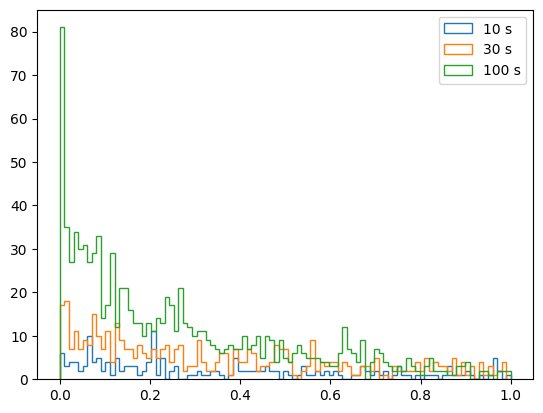

In [231]:
for t_d in t_ds:
    plt.hist(df_t_ds[t_d].apply(lambda row: ranker.rank(row), axis=1), 
             histtype='step',
             bins=np.linspace(0, 1, 100), 
             label=f'{t_d} s')
plt.legend()
plt.show()


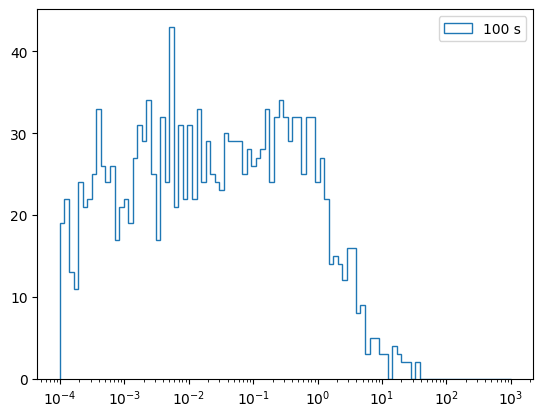

In [244]:
plt.hist(df_hits.head(10000).apply(lambda row: ranker.rank(row), axis=1), 
         histtype='step',
         bins=10**np.linspace(-4, 3, 100), 
         label=f'{t_d} s')
plt.xscale('log')
plt.legend()
plt.show()


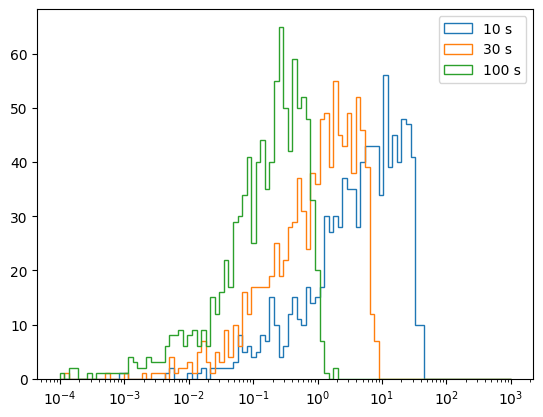

In [242]:
for t_d in t_ds:
    plt.hist(df_t_ds[t_d].apply(lambda row: ranker.rank(row), axis=1), 
             histtype='step',
             bins=10**np.linspace(-4, 3, 100), 
             label=f'{t_d} s')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
df_hits['rank'] = df_hits.apply(lambda row: ranker.rank(row), axis=1)
df_events['rank'] = df_events.apply(lambda row: ranker.rank(row), axis=1)

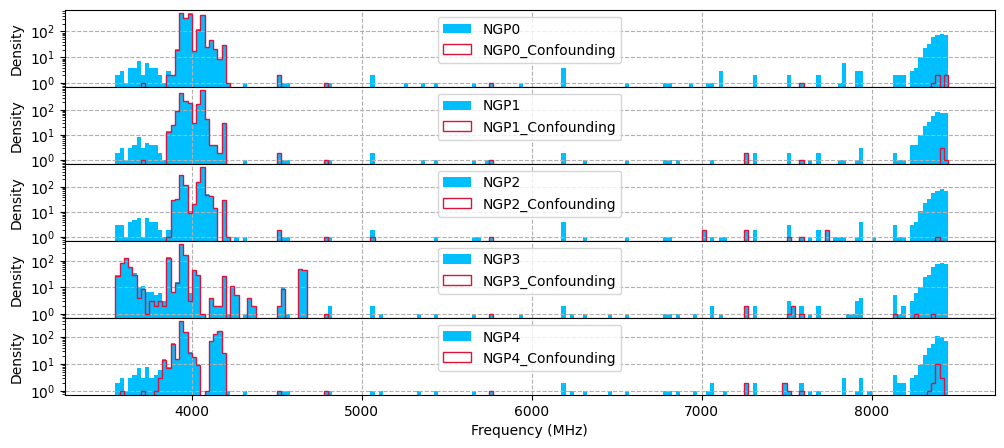

In [8]:

dbin = 25
bins_frequency = np.arange(3500, 8500, dbin)
colors = ['deepskyblue', 'crimson', 'crimson']

fig = plt.figure(figsize=(12, 5))

gs = grd.GridSpec(5, 
                  1, 
                  # height_ratios=[10, 10, 10, 6, 6], 
                  # width_ratios=[30, 1], 
                  # wspace=0., 
                  hspace=0.
                 )

for i, ngpp in enumerate(NGP_pointings):
    ax = plt.subplot(gs[i])
    plt.hist(ngpp.hits['Uncorrected_Frequency'], 
             bins=bins_frequency,
             alpha=1,
                            # histtype='step', 
             color=colors[0],
             label=f'NGP{ngpp.session_idx}')
    plt.hist(ngpp.hits[ngpp.hits['std'] > 0.5]['Uncorrected_Frequency'], 
             bins=bins_frequency,
             alpha=1,
                            histtype='step', 
             color=colors[2],
             label=f'NGP{ngpp.session_idx}_Confounding')
    plt.legend(loc=9)
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.grid(ls='--')
plt.xlabel('Frequency (MHz)')
plt.show()